## Inactive gene set QC 

1. Gene overlap with chromHMM states 
2. Gene overlap with GTEx whole blood RNA-seq 
3. Gene overlap with eGenes from eQTLGen and GTEx whole blood

### Gene overlap with chrom HMM states 

In [1]:
import pandas as pd 
import numpy as np
import sys
import glob
from collections import Counter
from pathlib import Path
from pybedtools import BedTool
import pysam
from io import StringIO
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import pyplot

In [2]:
wkdir="/lustre/scratch126/humgen/projects/interval_rna/interval_rna_seq/thomasVDS/misexpression_v3"
wkdir_path = Path(wkdir)

# inputs 
pbmc_chrom_hmm_path=wkdir_path.joinpath("reference/chromhmm/E062_15_coreMarks_hg38lift_mnemonics.bed.gz")
inactive_gene_path=wkdir_path.joinpath("1_rna_seq_qc/gene_sets/inactive_genes_8779.txt")
gencode_gtf_path=wkdir_path.joinpath("reference/gencode/gencode.v31.annotation.sorted.gtf.gz")
tpm_fract_path=wkdir_path.joinpath("1_rna_seq_qc/gene_sets/gene_tpm0.1_fract.csv")
out_dir=wkdir_path.joinpath("2_misexp_qc/")

In [3]:
out_dir_path = Path(out_dir)
out_dir_path.mkdir(parents=True, exist_ok=True)
chromhmm_dir_path = out_dir_path.joinpath("chrom_hmm")
chromhmm_dir_path.mkdir(parents=True, exist_ok=True)

In [4]:
### calculate fraction overlap for each ChromHMM state 
chromhmm_15states = ['1_TssA', '2_TssAFlnk', '3_TxFlnk', '4_Tx', '5_TxWk', '6_EnhG', '7_Enh', '8_ZNF/Rpts', '9_Het', 
                     '10_TssBiv', '11_BivFlnk', '12_EnhBiv', '13_ReprPC', '14_ReprPCWk', '15_Quies']

In [5]:
# write genes to bed file 
all_gene_bed_path = chromhmm_dir_path.joinpath("gencode.genes.bed")
gene_id_to_bed = []
with open(all_gene_bed_path, "w") as f:
    for gtf in pysam.TabixFile(str(gencode_gtf_path)).fetch(parser = pysam.asGTF()):
        if gtf.feature == "gene":
            chrom, start, end, gene_id = gtf.contig, gtf.start, gtf.end, gtf.gene_id
            gene_id_to_bed.append(gene_id)
            f.write(f"{chrom}\t{start}\t{end}\t{gene_id}\n")
print(f"Number of genes in bed file: {len(gene_id_to_bed)}")

# intersect chromatin states with gene bed file 
pbmc_chrom_hmm_bed = BedTool(pbmc_chrom_hmm_path)
all_gene_bed = BedTool(all_gene_bed_path)
all_gene_intersect_chromhmm_str = StringIO(str(all_gene_bed.intersect(pbmc_chrom_hmm_bed, wo=True)))
gene_chromhmm_cols = {0:"chrom_gene", 1:"start_gene", 2:"end_gene", 3:"gene_id",4:"state_chrom",
                      5:"state_start", 6:"state_end", 7:"state", 8:"overlap"
                     }
all_gene_intersect_chromhmm_df = pd.read_csv(all_gene_intersect_chromhmm_str, sep="\t", header=None).rename(columns=gene_chromhmm_cols)
# calculate fraction overlap
all_gene_intersect_chromhmm_df["gene_length"] = all_gene_intersect_chromhmm_df.end_gene - all_gene_intersect_chromhmm_df.start_gene
all_gene_intersect_chromhmm_df["pc_overlap"] = (all_gene_intersect_chromhmm_df.overlap/all_gene_intersect_chromhmm_df.gene_length) * 100

Number of genes in bed file: 60603


In [6]:
all_gene_id_state_overlap_df = pd.DataFrame(columns=["gene_id"] + chromhmm_15states)
for gene_id in gene_id_to_bed:
    gene_id_df = all_gene_intersect_chromhmm_df[all_gene_intersect_chromhmm_df.gene_id == gene_id]
    # fraction overlap for each state 
    gene_pc_overlap_list = [0 if gene_id_df[gene_id_df["state"] == state].shape[0] == 0 else gene_id_df[gene_id_df["state"] == state].pc_overlap.sum() for state in chromhmm_15states]
    # add to dataframe 
    all_gene_id_state_overlap_df.loc[len(all_gene_id_state_overlap_df)] = [gene_id] + gene_pc_overlap_list

In [7]:
# write to output 
gene_overlap_path = chromhmm_dir_path.joinpath("gene_chromhmm_state_overlap.csv")
all_gene_id_state_overlap_df.to_csv(gene_overlap_path, index=False)

In [8]:
# read in to avoid running above again 
gene_overlap_path = chromhmm_dir_path.joinpath("gene_chromhmm_state_overlap.csv")
all_gene_id_state_overlap_df = pd.read_csv(gene_overlap_path)

In [9]:
# check genes with limited chromatin state overlap is low 
gene_id_low_overlap_df = all_gene_id_state_overlap_df[all_gene_id_state_overlap_df[chromhmm_15states].sum(axis=1) < 90]
print(f"Number of gene IDs with limited state overlap: {gene_id_low_overlap_df.shape[0]}")

Number of gene IDs with limited state overlap: 833


kmeans_2_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


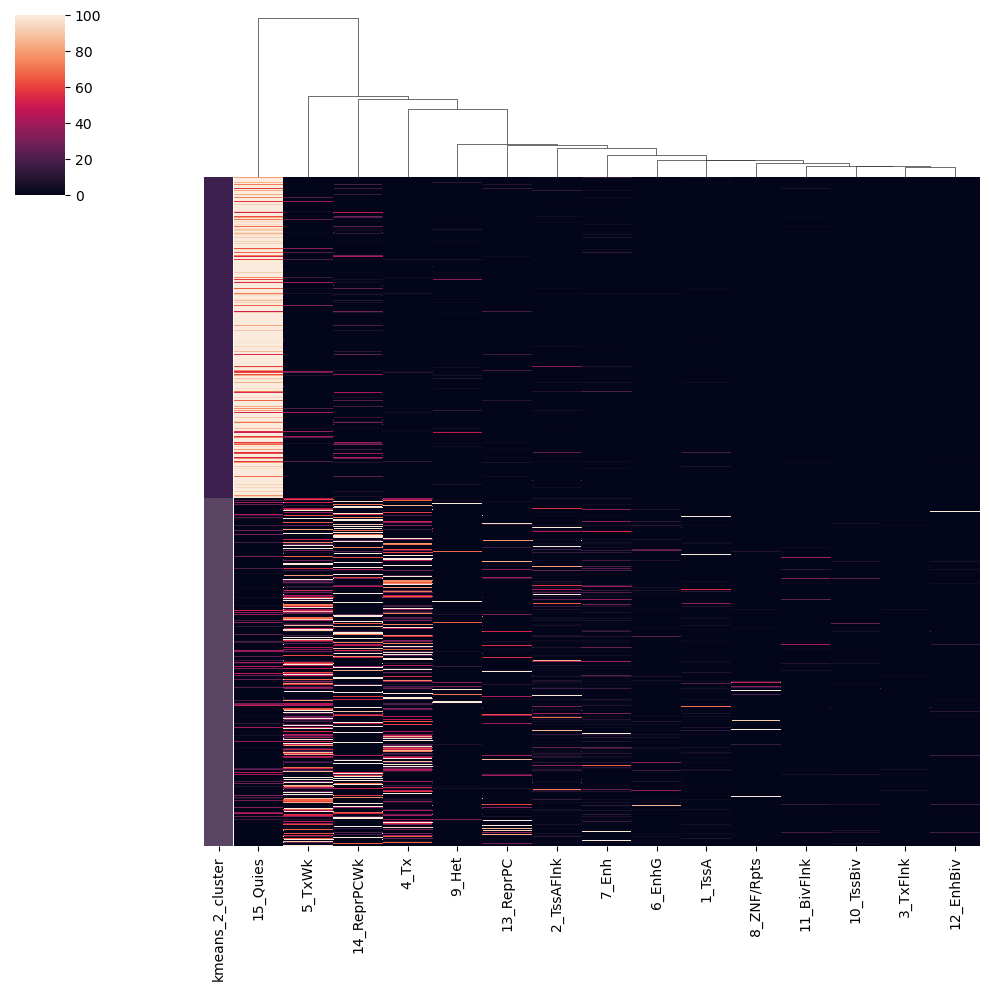

kmeans_3_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


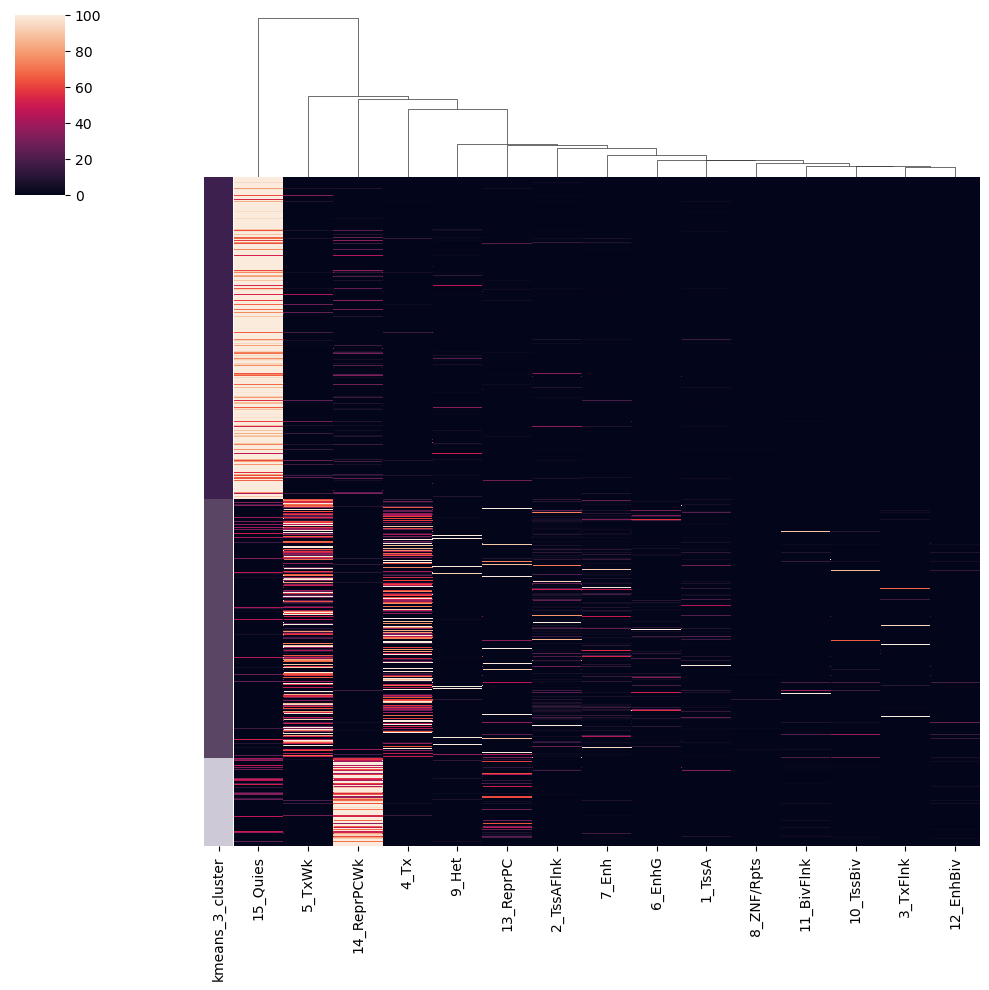

kmeans_4_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


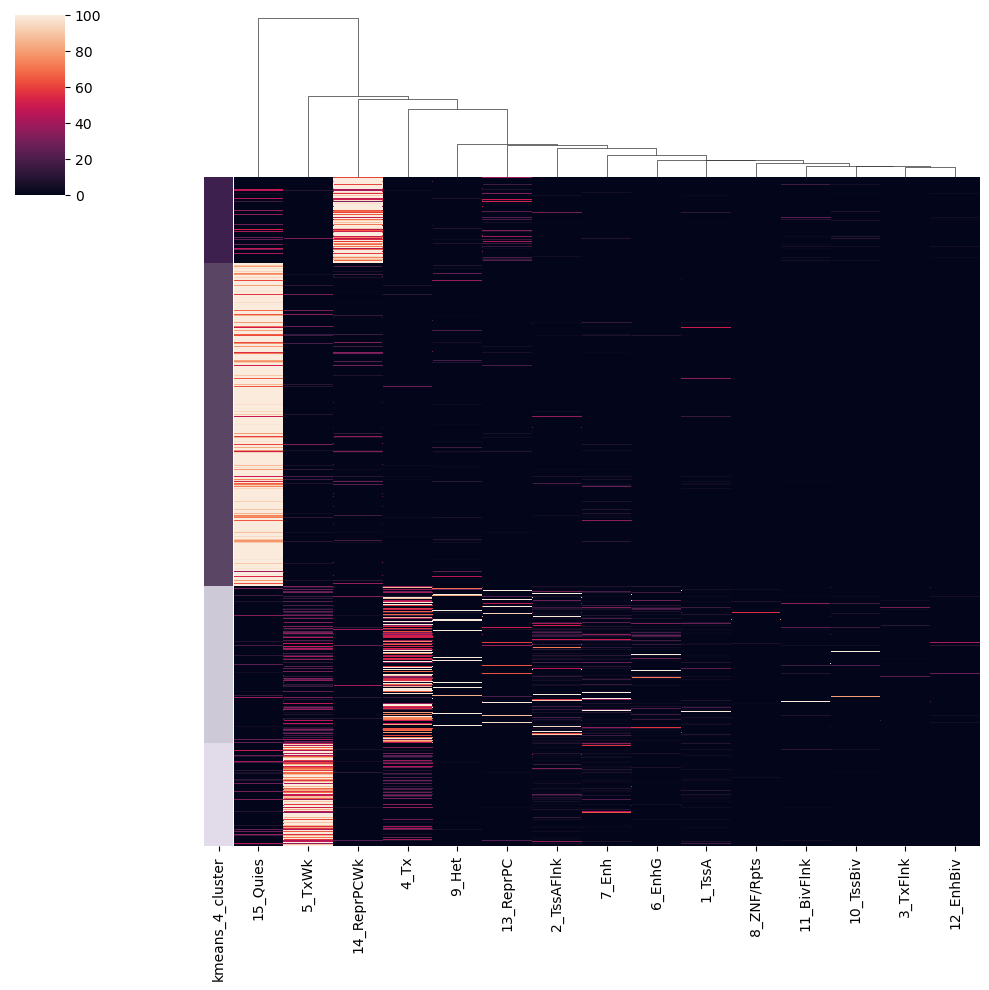

kmeans_5_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


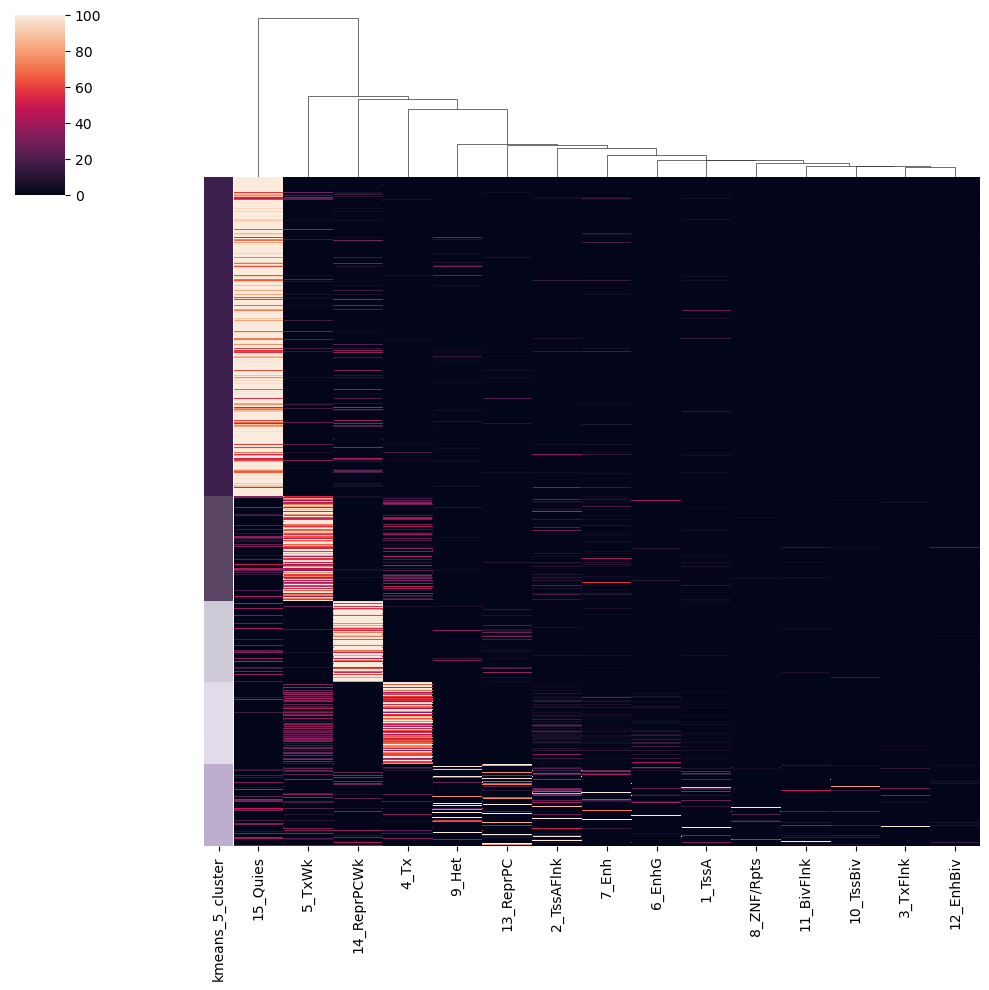

kmeans_6_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


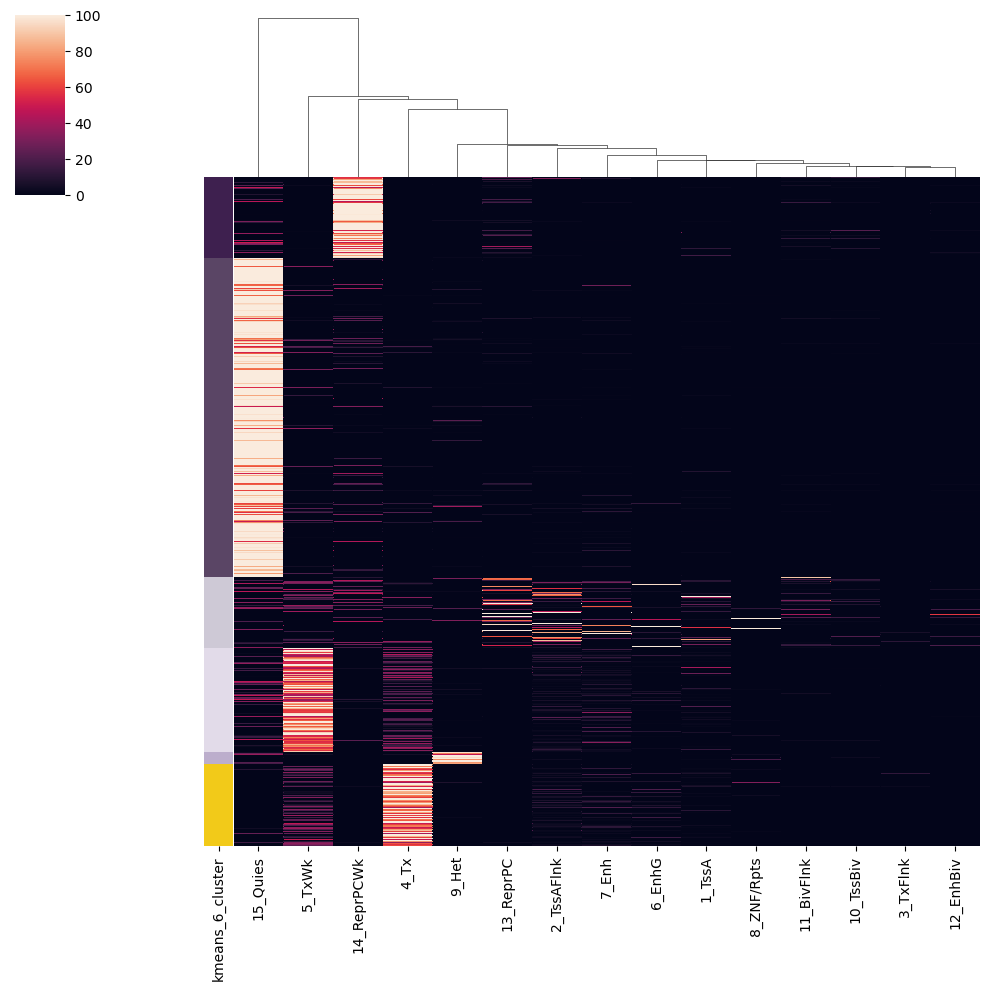

kmeans_7_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


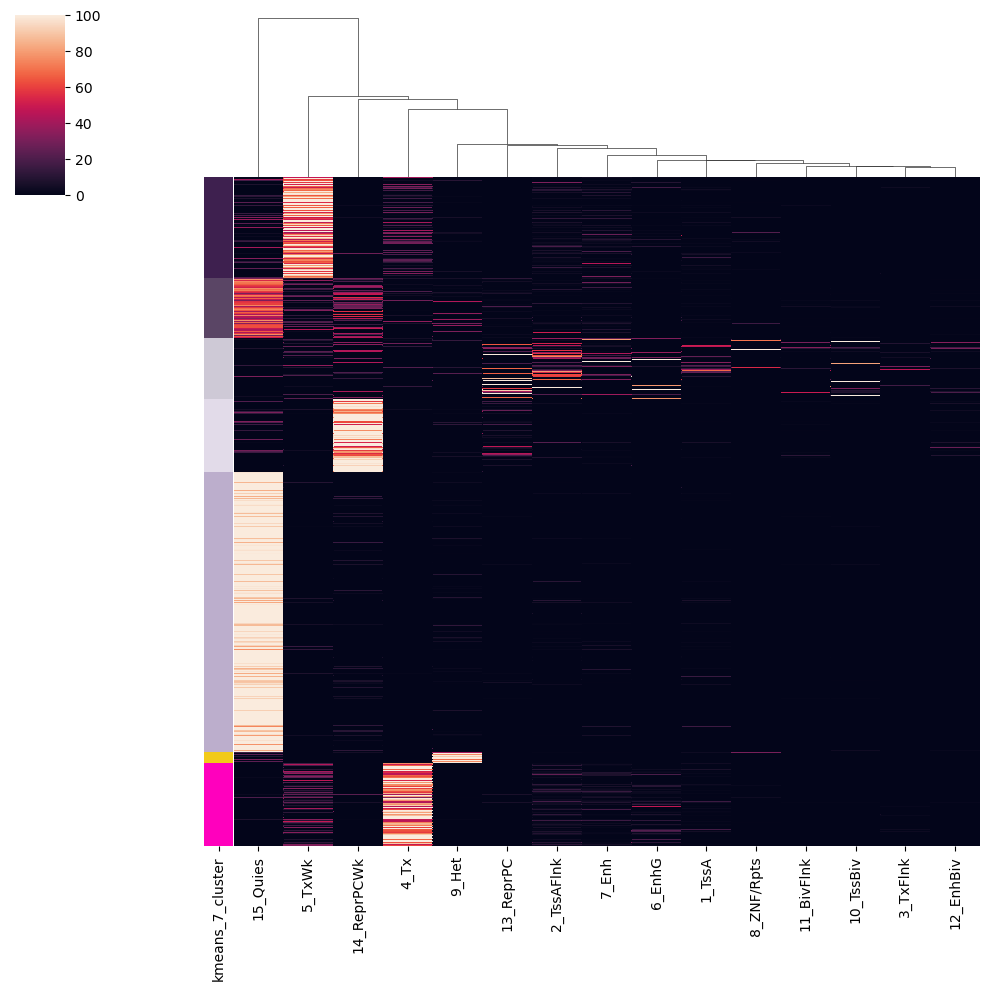

kmeans_8_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


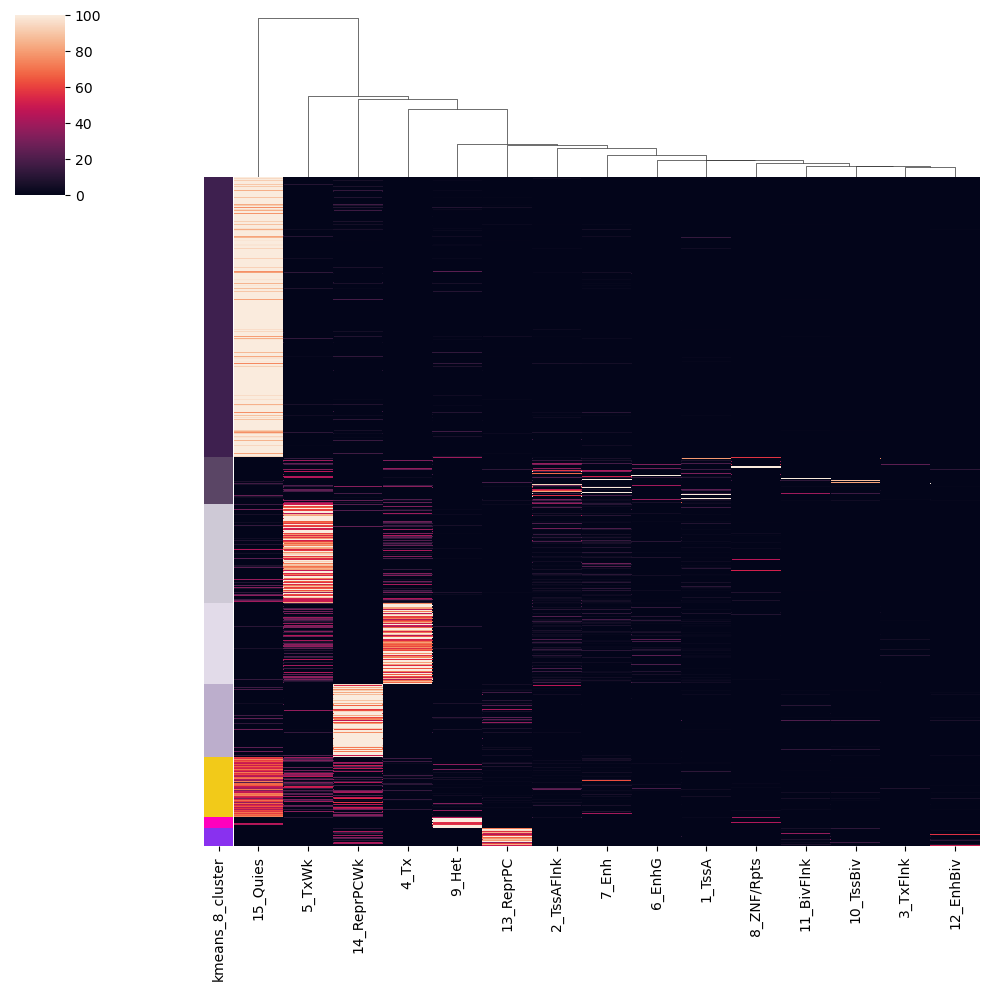

kmeans_9_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


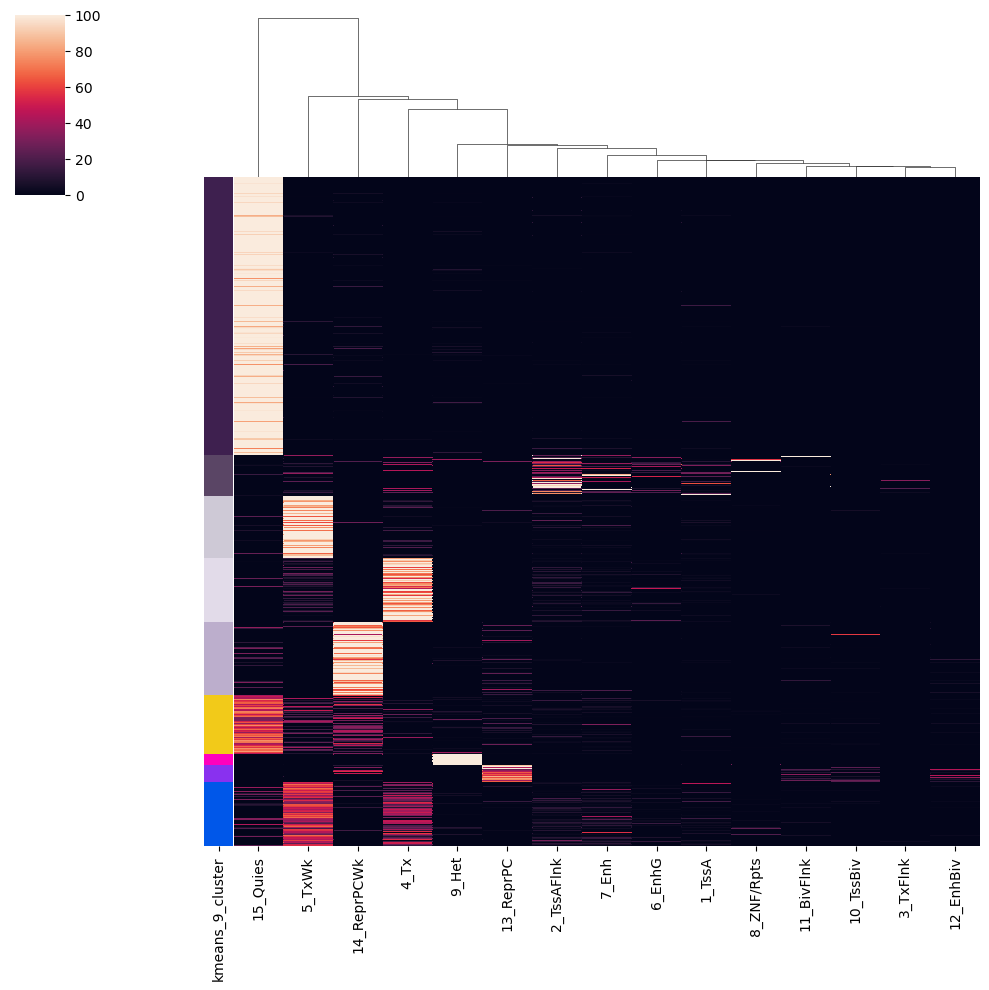

kmeans_10_cluster


/nfs/users/nfs_t/tv5/.conda/envs/tv5_base/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


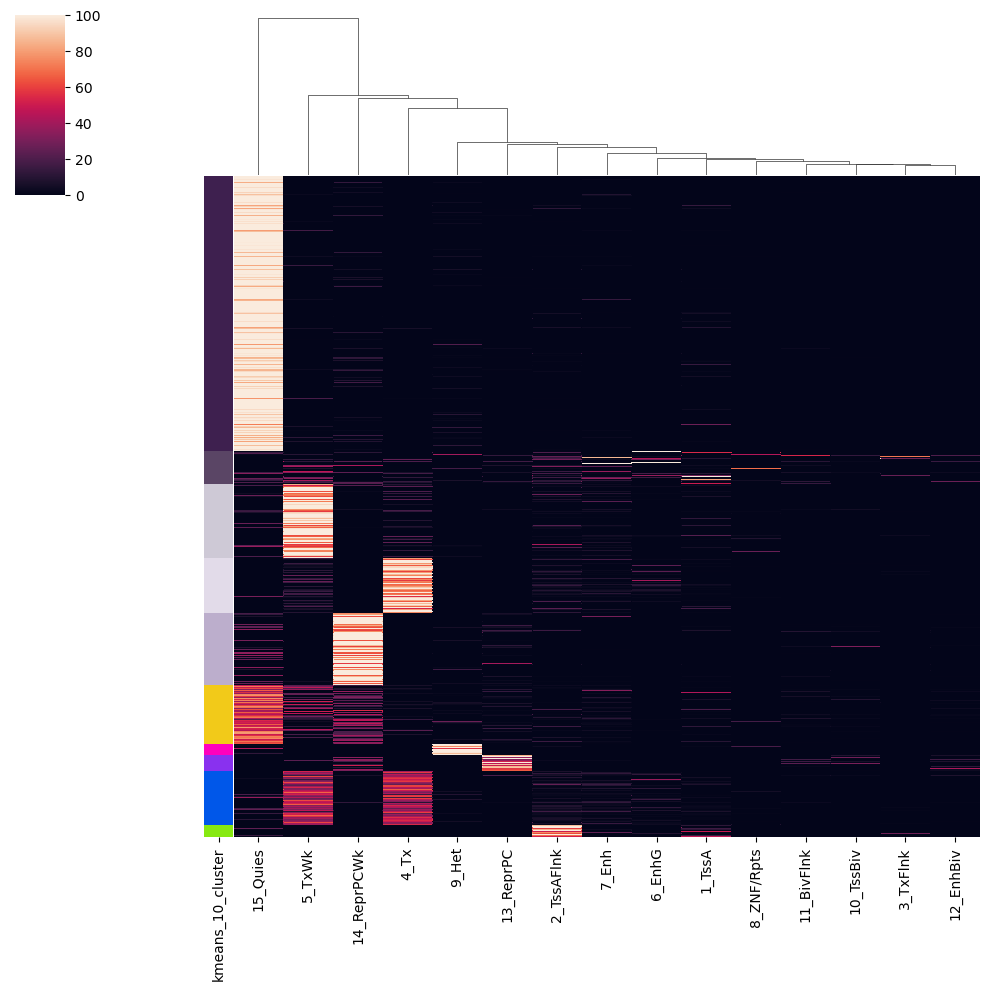

In [10]:
# k-means clustering of genes by overlapping chromatin states 
gene_overlap_kmeans_cluster_df = all_gene_id_state_overlap_df.copy()
kmeans_input = all_gene_id_state_overlap_df[chromhmm_15states].to_numpy()
# testing k = 2-10 clusters
n_cluster_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# cluster colors 
colors = ["#3e204f", "#5a4565", "#cec9d6", "#e2dbe9", 
          "#bcaecc", '#f2ca19', '#ff00bd', "#8931ef",
          "#0057e9", "#87e911"
         ]

for n_cluster in n_cluster_list:
    cluster_label = f"kmeans_{n_cluster}_cluster"
    print(cluster_label)
    kmeans_clusters = KMeans(n_clusters=n_cluster, random_state=0).fit(kmeans_input)
    # save cluster annotations 
    gene_overlap_kmeans_cluster_df[cluster_label] = kmeans_clusters.labels_
    # plot heatmap 
    sorted_df = gene_overlap_kmeans_cluster_df.sort_values(by=cluster_label, ascending=True)
    clusters = sorted_df.pop(cluster_label)
    lut = dict(zip(clusters.unique(), colors))
    row_colors=clusters.map(lut)
    heatmap_plot = sorted_df[chromhmm_15states]
    g = sns.clustermap(data=heatmap_plot.astype(float), 
                       row_cluster=False, 
                       col_cluster=True,
                       row_colors=row_colors, 
                       yticklabels=False
                      )  
    plt.show()

Number of inactive genes: 8779
Genes annotated: 8779
Active genes: 1229 , Inactive genes: 7550


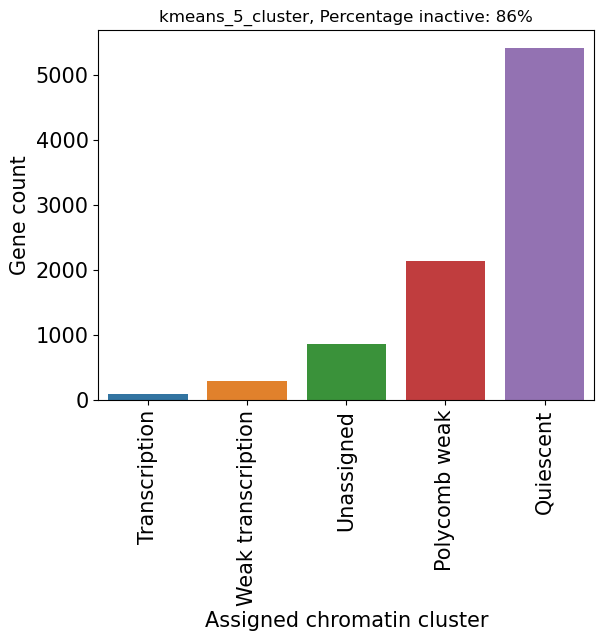

Genes annotated: 8779
Active genes: 1151 , Inactive genes: 7628


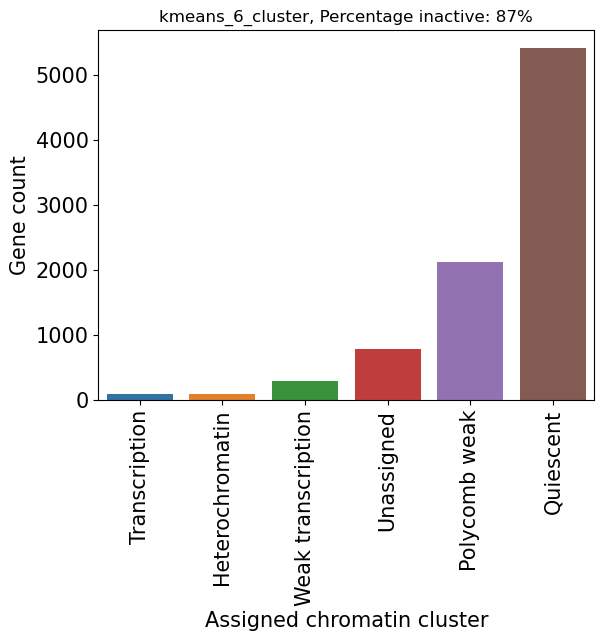

Genes annotated: 8779
Active genes: 1060 , Inactive genes: 7719


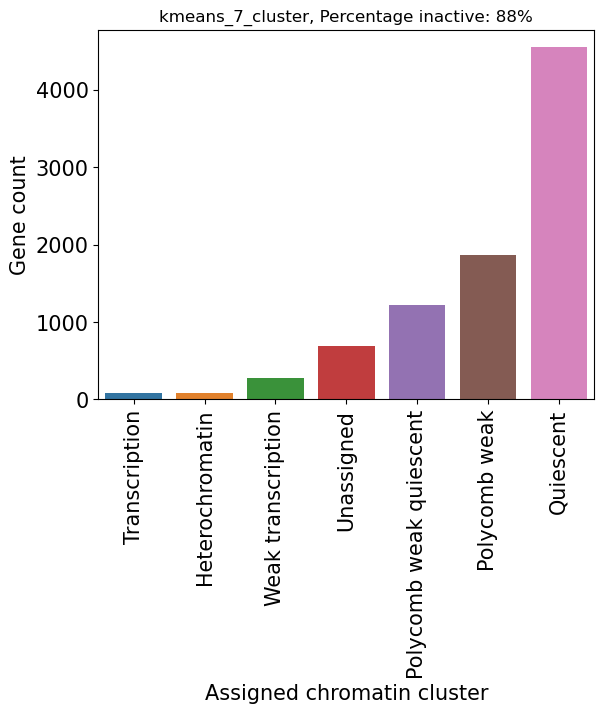

Genes annotated: 8779
Active genes: 502 , Inactive genes: 8277


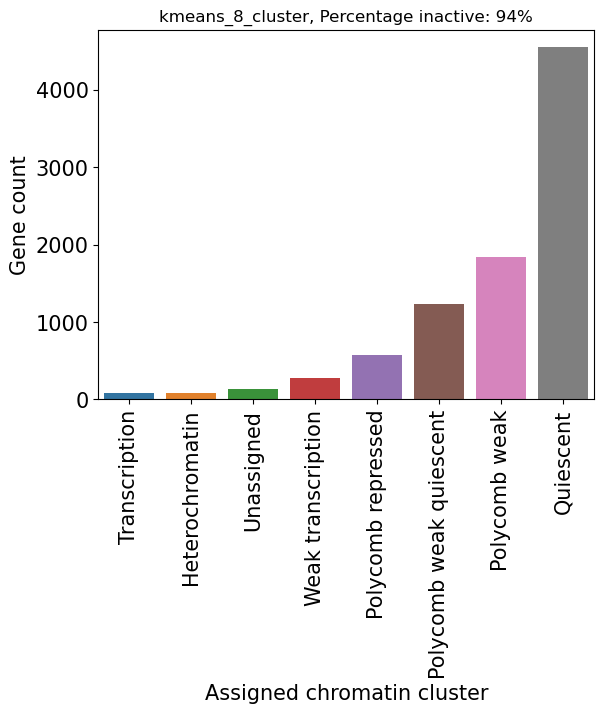

In [11]:
# inactive gene list 
inactive_genes_list = pd.read_csv(inactive_gene_path, header=None)[0].tolist()
print(f"Number of inactive genes: {len(inactive_genes_list)}")

### comparison of clusters k = 5-8

# manual annotation of clusters
manual_cluster_annot = {'kmeans_5_cluster': {0: "Quiescent", 
                                            3: "Transcription", 
                                            1: "Weak transcription",
                                            2: "Polycomb weak", 
                                            4: "Unassigned"}, 
                        'kmeans_6_cluster': {1: "Quiescent", 
                                            5: "Transcription", 
                                            3: "Weak transcription",
                                            0: "Polycomb weak",
                                            4: "Heterochromatin",
                                            2: "Unassigned"}, 
                        'kmeans_7_cluster': {4: "Quiescent", 
                                            6: "Transcription",
                                            1: "Polycomb weak quiescent",
                                            0: "Weak transcription",
                                            2: "Unassigned",
                                            3: "Polycomb weak", 
                                            5: "Heterochromatin"}, 
                        'kmeans_8_cluster': {0: "Quiescent", 
                                            3: "Transcription", 
                                            4: "Polycomb weak",
                                            2: "Weak transcription", 
                                            1: "Unassigned",
                                            5: "Polycomb weak quiescent",
                                            7: "Polycomb repressed",
                                            6: "Heterochromatin"}, 
                       }

# define active and inactive clusters 
active_clusters = ["Transcription", "Weak transcription", "Unassigned"]
inactive_clusters = ["Quiescent", "Polycomb weak", "Polycomb weak quiescent", 
                     "Polycomb repressed", "Heterochromatin"]

for n_cluster in n_cluster_list[3:7]:
    cluster_label = f"kmeans_{n_cluster}_cluster"
    k_clusters_genes_df = gene_overlap_kmeans_cluster_df[["gene_id", cluster_label]]
    k_clusters_genes_annotated_df = k_clusters_genes_df.replace(manual_cluster_annot[cluster_label])
    k_clusters_genes_annotated_df["gene_id"] = k_clusters_genes_annotated_df.gene_id.str.split(".").str[0]
    # subset to inactive genes 
    inactive_genes_k_clusters_df = k_clusters_genes_annotated_df[k_clusters_genes_annotated_df.gene_id.isin(inactive_genes_list)].copy()
    count_gene_by_cluster_df = pd.DataFrame.from_dict(Counter(inactive_genes_k_clusters_df[cluster_label].tolist()),
                                                          orient="index", 
                                                          columns=["gene_count"]).sort_values(by="gene_count", ascending=True)
    # inactive to active ratio 
    active_genes = count_gene_by_cluster_df[count_gene_by_cluster_df.index.isin(active_clusters)].gene_count.sum()
    inactive_genes = count_gene_by_cluster_df[count_gene_by_cluster_df.index.isin(inactive_clusters)].gene_count.sum()
    ratio = inactive_genes/(active_genes+inactive_genes)
    print(f"Genes annotated: {active_genes+inactive_genes}")
    print(f"Active genes: {active_genes} , Inactive genes: {inactive_genes}")
    # barplot for inactive gene cluster annotations 
    ax = sns.barplot(data=count_gene_by_cluster_df.reset_index(), 
                x="index",
                y="gene_count")
    plt.xticks(rotation=90)
    ax.set_title(f"{cluster_label}, Percentage inactive: {round(ratio*100)}%")
    ax.set_xlabel("Assigned chromatin cluster", size=15)
    ax.set_ylabel("Gene count", size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

In [12]:
# select k=8 clusters
# write cluster assignment for inactive genes 
group="kmeans_8_cluster"
#inactive_genes_k_clusters_df = k_clusters_genes_annotated_df[k_clusters_genes_annotated_df.gene_id.isin(intrvl_inactive_genes_list)].copy()
all_gene_id_kmeans_8_df = gene_overlap_kmeans_cluster_df[["gene_id", group] + chromhmm_15states].copy()
all_gene_id_kmeans_8_df["gene_id"] = all_gene_id_kmeans_8_df.gene_id.str.split(".").str[0]
all_gene_id_kmeans_8_df["inactive_rnaseq"] = np.where(all_gene_id_kmeans_8_df.gene_id.isin(inactive_genes_list), True, False)
all_gene_id_kmeans8_label_df = all_gene_id_kmeans_8_df.replace({group: manual_cluster_annot[group]}) 

# order dataframe and add inactive, active and unassigned labels
annot_order = ["Transcription", "Weak transcription", "Unassigned", "Quiescent", 
               "Polycomb weak quiescent", "Polycomb weak", "Polycomb repressed", 
               "Heterochromatin"]
cluster_status_dict = {"Transcription": "Active", 
                       "Weak transcription": "Active",
                       "Unassigned": "Unassigned", 
                       "Quiescent": "Inactive", 
                       "Polycomb weak quiescent": "Inactive", 
                       "Polycomb weak": "Inactive", 
                       "Polycomb repressed": "Inactive", 
                       "Heterochromatin": "Inactive"
                      }

all_gene_id_kmeans8_label_srtd_df = all_gene_id_kmeans8_label_df.set_index(group).loc[annot_order].reset_index()
all_gene_id_kmeans8_label_srtd_df["group"] = all_gene_id_kmeans8_label_srtd_df.kmeans_8_cluster.replace(cluster_status_dict)
# add TPM fraction < 0.1 and subset to genes from test set (n=29,614)
tpm_fract_df = pd.read_csv(tpm_fract_path)
all_gene_id_kmeans8_label_tpm_fract_df = pd.merge(all_gene_id_kmeans8_label_srtd_df, 
                                                  tpm_fract_df, 
                                                  on="gene_id", 
                                                  how="inner"
                                                 )
bins = [(i*5)/100 for i in range(21)]
labels = [f"{(i*5)}-{((i+1)*5)}%" for i in range(20)]
all_gene_id_kmeans8_label_tpm_fract_df["tpm0.1_fract_bins"] = pd.cut(all_gene_id_kmeans8_label_tpm_fract_df['tpm0.1_fract'], bins=bins, labels=labels, include_lowest=True)

In [13]:
# count number of genes in each k-means cluster in each TPM fraction bin 
count_cluster_tpm_fract_df = all_gene_id_kmeans8_label_tpm_fract_df.groupby(["tpm0.1_fract_bins", "kmeans_8_cluster"], as_index=False).gene_id.count()
count_cluster_tpm_fract_df = count_cluster_tpm_fract_df.rename(columns={"gene_id":"gene_count"})
# count number of genes in active/inactive/unassigned group in each TPM fraction bin 
count_active_inactive_tpm_fract_df = all_gene_id_kmeans8_label_tpm_fract_df.groupby(["tpm0.1_fract_bins", "group"], as_index=False).gene_id.count()
count_active_inactive_tpm_fract_df = count_active_inactive_tpm_fract_df.rename(columns={"group":"activity", "gene_id": "gene_count"})

In [14]:
# proportion of genes within inactive 0-5% bin
inactive_gene_tpm01_5perc = count_active_inactive_tpm_fract_df[(count_active_inactive_tpm_fract_df["tpm0.1_fract_bins"] == "0-5%") & 
                                   (count_active_inactive_tpm_fract_df["activity"] == "Inactive")
                                  ].gene_count.item()
print(f"Number of inactive genes in 0-5% bin: {inactive_gene_tpm01_5perc}")

Number of inactive genes in 0-5% bin: 8277


In [15]:
# write to file 
all_gene_id_kmeans8_label_path = chromhmm_dir_path.joinpath(f"gene_chromhmm_state_overlap_{group}_results.csv")
all_gene_id_kmeans8_label_tpm_fract_df.to_csv(all_gene_id_kmeans8_label_path, index=False)

count_cluster_tpm_fract_path = chromhmm_dir_path.joinpath(f"tpm_fract_chromhmm_cluster_count.csv")
count_cluster_tpm_fract_df.to_csv(count_cluster_tpm_fract_path, index=False)

count_active_inactive_tpm_fract_path = chromhmm_dir_path.joinpath(f"tpm_fract_active_inactive_count.csv")
count_active_inactive_tpm_fract_df.to_csv(count_active_inactive_tpm_fract_path, index=False)

### GTEx whole blood RNA-seq QC for inactive genes comparison

In [16]:
# inputs
gtex_tpm_mtx_path = wkdir_path.joinpath("reference/gtex/tpm_wb/gene_tpm_2017-06-05_v8_whole_blood.tsv")
gtex_covariates_path = wkdir_path.joinpath("reference/gtex/eqtl/GTEx_Analysis_v8_eQTL_EUR/expression_covariates/Whole_Blood.v8.EUR.covariates.txt")

# variables 
tpm_fract_cutoff = 0.1 
smpl_perc_cutoff = 0.05 
aberrant_multiple = 5

In [17]:
# load TPM matrix 
gtex_tpm_mtx_df = pd.read_csv(gtex_tpm_mtx_path, sep="\t")
gtex_tpm_mtx_clean_df = gtex_tpm_mtx_df.drop(columns=["id", "Description"]).set_index("Name").sort_index()
# build dictionary linking sample ID to truncated ID used in covariate file 
gtex_ids_trunc_dict = {f"{gtex_id.split('-')[0]}-{gtex_id.split('-')[1]}":gtex_id for gtex_id in gtex_tpm_mtx_clean_df.columns.tolist()}
gtex_ids_trunc = set(gtex_ids_trunc_dict.keys())
print(f"Number of samples in expression matrix: {gtex_tpm_mtx_clean_df.shape[1]}")
print(f"Number of genes in expression matrix: {gtex_tpm_mtx_clean_df.shape[0]}")
### removal of non-European samples 
# load covariates for eQTL mapping
eur_covs_df = pd.read_csv(gtex_covariates_path, sep="\t")
eur_smpls = set(eur_covs_df.set_index("ID").columns)
print(f"Number of European samples in eQTL covariates file: {len(eur_smpls)}")
# overlap between covariate IDs and truncated ge matrix IDs 
eur_smpls_intersect = eur_smpls.intersection(gtex_ids_trunc)
print(f"Number of European samples in both eQTL covariates and TPM matrix: {len(eur_smpls_intersect)}")
# get full IDs which overlap 
eur_smpls_intersect_full = [gtex_ids_trunc_dict[gtex_id] for gtex_id in eur_smpls_intersect]
# subset expression dataframe 
gtex_tpm_mtx_clean_eur_df = gtex_tpm_mtx_clean_df[eur_smpls_intersect_full]
if len(eur_smpls) != len(gtex_tpm_mtx_clean_eur_df.columns): 
    raise ValueError("Missing sample names from TPM dataframe")

Number of samples in expression matrix: 755
Number of genes in expression matrix: 56200
Number of European samples in eQTL covariates file: 558
Number of European samples in both eQTL covariates and TPM matrix: 558


In [18]:
### remove samples with high numbers of top expression events 
# remove genes that have a TPM = 0 across all samples
total_genes = len(gtex_tpm_mtx_clean_eur_df.index.tolist())
print(f"Total number of genes in TPM matrix: {total_genes}")
gtex_tpm_mtx_clean_eur_nozeroes_df = gtex_tpm_mtx_clean_eur_df.loc[~(gtex_tpm_mtx_clean_eur_df==0).all(axis=1)]
total_genes_to_count = gtex_tpm_mtx_clean_eur_nozeroes_df.shape[0]
print(f"Total number genes in TPM matrix with at least one non-zero sample: {total_genes_to_count}")
# calculate aberrant sample cutoff limit 
eur_smpl_number = len(eur_smpls_intersect)
exp_top_exp_events = total_genes_to_count/eur_smpl_number
# count max sample for each gene 
max_gene_per_smpl_dict = Counter(gtex_tpm_mtx_clean_eur_nozeroes_df.idxmax(axis=1).tolist())
max_gene_per_smpl_df = pd.DataFrame.from_dict(max_gene_per_smpl_dict, orient="index", columns=["count"]).reset_index(drop=False).rename(columns={"index":"sample_id"})
# add samples with no top misexpression events 
smpl_with_no_top_event_dict = {smpl_id: 0 for smpl_id in eur_smpls_intersect_full if smpl_id not in max_gene_per_smpl_dict.keys()}
smpl_with_no_top_event_df = pd.DataFrame.from_dict(smpl_with_no_top_event_dict, orient="index", columns=["count"]).reset_index(drop=False).rename(columns={"index":"sample_id"})
max_gene_per_all_smpl_df = pd.concat([max_gene_per_smpl_df, smpl_with_no_top_event_df]).reset_index(drop=True)
# check number of genes counted matches total input genes 
top_gene_count = max_gene_per_all_smpl_df['count'].sum()
if top_gene_count != total_genes_to_count: 
    raise ValuerError("Total number of top expression events does not match input genes")
# count samples passing and failing QC 
max_gene_per_all_smpl_df["passed_qc"] = np.where(max_gene_per_all_smpl_df["count"] > exp_top_exp_events * aberrant_multiple, False, True) 
smpl_id_pass_qc = max_gene_per_all_smpl_df[max_gene_per_all_smpl_df["passed_qc"]].sample_id.tolist()
smpl_id_fail_qc = max_gene_per_all_smpl_df[~max_gene_per_all_smpl_df["passed_qc"]].sample_id.tolist()
print(f"Number of samples passing QC: {len(smpl_id_pass_qc)}")
print(f"Number of samples failing QC: {len(smpl_id_fail_qc)}")

Total number of genes in TPM matrix: 56200
Total number genes in TPM matrix with at least one non-zero sample: 52749
Number of samples passing QC: 540
Number of samples failing QC: 18


In [19]:
# check that max method does not bias samples in nearer column
# reverse dataframe 
gtex_tpm_mtx_clean_eur_nozeroes_rev_df = gtex_tpm_mtx_clean_eur_nozeroes_df.iloc[:, ::-1]
# count max sample for each gene 
max_gene_per_smpl_rev_dict = Counter(gtex_tpm_mtx_clean_eur_nozeroes_rev_df.idxmax(axis=1).tolist())
max_gene_per_smpl_rev_df = pd.DataFrame.from_dict(max_gene_per_smpl_rev_dict, orient="index", columns=["count_rev"]).reset_index(drop=False).rename(columns={"index":"sample_id"})
# add samples with no top misexpression events 
smpl_with_no_top_event_rev_dict = {smpl_id: 0 for smpl_id in eur_smpls_intersect_full if smpl_id not in max_gene_per_smpl_rev_dict.keys()}
smpl_with_no_top_event_rev_df = pd.DataFrame.from_dict(smpl_with_no_top_event_rev_dict, orient="index", columns=["count_rev"]).reset_index(drop=False).rename(columns={"index":"sample_id"})
max_gene_per_smpl_all_rev_df = pd.concat([max_gene_per_smpl_rev_df, smpl_with_no_top_event_rev_df]).reset_index(drop=True)
# check number of genes counted matches total input genes 
top_gene_count_rev = max_gene_per_all_smpl_df['count'].sum()
if top_gene_count_rev != total_genes_to_count: 
    raise ValuerError("Total number of top expression events does not match input genes (reverse)")
# count samples passing and failing QC (reversed columns)
max_gene_per_smpl_all_rev_df["passed_qc_rev"] = np.where(max_gene_per_smpl_all_rev_df["count_rev"] > exp_top_exp_events * 5, False, True) 
smpl_id_pass_qc_rev = max_gene_per_all_smpl_df[max_gene_per_all_smpl_df["passed_qc"]].sample_id.tolist()
smpl_id_fail_qc_rev = max_gene_per_all_smpl_df[~max_gene_per_all_smpl_df["passed_qc"]].sample_id.tolist()
# check similarity with samples passing QC with reverse 
if smpl_id_pass_qc != smpl_id_pass_qc_rev:
    raise ValueError("Reversing dataframe changes samples passing QC.")
# subset gene expression matrix
gtex_tpm_mtx_pass_smpl_qc_df = gtex_tpm_mtx_clean_eur_df[smpl_id_pass_qc]

In [20]:
### gene-level QC 
gtex_smpl_ids_list = gtex_tpm_mtx_pass_smpl_qc_df.columns
gtex_smpl_number = len(gtex_smpl_ids_list)
# compute TPM < 0.1 fraction per gene 
gtex_tpm_fract_df = gtex_tpm_mtx_pass_smpl_qc_df.reset_index(drop=False)[["Name"]].copy()
gtex_tpm_fract_df[f"tpm{tpm_fract_cutoff}_fract"] = ((gtex_tpm_mtx_pass_smpl_qc_df > tpm_fract_cutoff).sum(axis=1)/gtex_smpl_number).tolist()
gtex_tpm_fract_df = gtex_tpm_fract_df.rename(columns={"Name": "gene_id"})
# label and subset TPM fraction dataframe to genes passing filters
gtex_gene_ids_grtr_smpl_perc = gtex_tpm_fract_df[gtex_tpm_fract_df[f"tpm{tpm_fract_cutoff}_fract"] < smpl_perc_cutoff]
# subset TPM matrix to inactive genes 
gtex_gene_ids_pass_cutoff = gtex_gene_ids_grtr_smpl_perc.gene_id.tolist()
tpm_mtx_pass_smpl_gene_qc_df = gtex_tpm_mtx_pass_smpl_qc_df[gtex_tpm_mtx_pass_smpl_qc_df.index.isin(gtex_gene_ids_pass_cutoff)].copy()

In [21]:
# write GTEx TPM fraction to file
gtex_out_dir = out_dir.joinpath("gtex_wb")
gtex_out_dir.mkdir(parents=True, exist_ok=True)
gtex_tpm_fract_path = gtex_out_dir.joinpath("gtex_wb_tpm_fract.tsv")
gtex_tpm_fract_df.to_csv(gtex_tpm_fract_path, sep="\t", index=False)

In [22]:
# load INTERVAL TPM < 0.1 sample fraction 
intrvl_genes_pass_filters = tpm_fract_df.gene_id.tolist()
print(f"Number of genes passing filters in INTERVAL: {len(intrvl_genes_pass_filters)}")
intrvl_inactive_genes = tpm_fract_df[tpm_fract_df[f"tpm{tpm_fract_cutoff}_fract"] < smpl_perc_cutoff].gene_id.unique()
print(f"INTERVAL, number of genes TPM > 0.1 in < 5% samples: {len(intrvl_inactive_genes)}")

Number of genes passing filters in INTERVAL: 29614
INTERVAL, number of genes TPM > 0.1 in < 5% samples: 8779


In [24]:
gtex_tpm_fract_df["gene_id"] = gtex_tpm_fract_df.gene_id.str.split(".").str[0]
gtex_tpm_fract_pass_filters_df = gtex_tpm_fract_df[gtex_tpm_fract_df.gene_id.isin(intrvl_genes_pass_filters)]
gtex_inactive_genes = gtex_tpm_fract_pass_filters_df[gtex_tpm_fract_pass_filters_df[f"tpm{tpm_fract_cutoff}_fract"] < smpl_perc_cutoff].gene_id.unique()
print(f"GTEx, number of genes TPM > 0.1 in < 5% samples: {len(gtex_inactive_genes)}")

# % of genes in INTERVAL also in inactive group in GTEx 
gtex_intrvl_inactive_overlap = [gene_id for gene_id in intrvl_inactive_genes if gene_id in gtex_inactive_genes]
pc_intrvl_inactive_in_gtex = (len(gtex_intrvl_inactive_overlap)/len(intrvl_inactive_genes)) * 100
print(f"Percentage of INTERVAL inactive genes in GTEx inactive group: {round(pc_intrvl_inactive_in_gtex, 2)}%")

jaccard_idx = len(set(intrvl_inactive_genes).intersection(set(gtex_inactive_genes)))/len(set(intrvl_inactive_genes).union(set(gtex_inactive_genes)))
print(f"Jaccard index for GTEx and INTERVAL inacive genes: {jaccard_idx}")

GTEx, number of genes TPM > 0.1 in < 5% samples: 8207
Percentage of INTERVAL inactive genes in GTEx inactive group: 79.74%
Jaccard index for GTEx and INTERVAL inacive genes: 0.7009813739234929


In [32]:
intrvl_gtex_tpm_fract_df = pd.merge(gtex_tpm_fract_df.rename(columns={"tpm0.1_fract":"tpm0.1_fract_gtex"}), 
                                    tpm_fract_df.rename(columns={"tpm0.1_fract":"tpm0.1_fract_interval"}), 
                                    on="gene_id", 
                                    how="inner")
intrvl_gtex_tpm_fract_df["difference"] = intrvl_gtex_tpm_fract_df["tpm0.1_fract_interval"] - intrvl_gtex_tpm_fract_df["tpm0.1_fract_gtex"]
intrvl_gtex_tpm_fract_df["inactive"] = np.where(intrvl_gtex_tpm_fract_df["tpm0.1_fract_interval"] < 0.05, "Inactive", "Not inactive")
intrvl_gtex_tpm_fract_path = gtexrstudio_out_dir.joinpath("intrvl_gtex_wb_tpm_fract.tsv")
intrvl_gtex_tpm_fract_df.to_csv(intrvl_gtex_tpm_fract_path, sep="\t", index=False)

In [37]:
gtex_interval_corr = intrvl_gtex_tpm_fract_df["tpm0.1_fract_gtex"].corr(intrvl_gtex_tpm_fract_df["tpm0.1_fract_interval"], method="spearman")
print(f"Spearman correlation between GTEx and INTERVAL TPM fraction: {gtex_interval_corr}")

Spearman correlation between GTEx and INTERVAL TPM fraction: 0.9233579514594329


### Check inactive gene overlap with eGenes from GTEx and eQTLGen

In [37]:
# inputs 
gtex_wb_egenes_path=wkdir_path.joinpath("reference/gtex/eqtl/GTEx_Analysis_v8_eQTL_EUR/eqtls/Whole_Blood.v8.EUR.egenes.txt.gz")
eqtlgen_egenes_path=wkdir_path.joinpath("reference/eqtlgen/2019-12-11-cis-eQTLsFDR-ProbeLevel-CohortInfoRemoved-BonferroniAdded.txt.gz")

In [38]:
# INTERVAL inactive genes 
intrvl_inactive_genes = pd.read_csv(inactive_genes_path, header=None)[0].tolist()
print(f"Number of inactive genes in INTERVAL: {len(intrvl_inactive_genes)}")

# GTEx whole blood eGenes 
gtex_wb_egenes_df = pd.read_csv(gtex_wb_egenes_path, sep="\t")
egenes_wb_gtex = gtex_wb_egenes_df.phenotype_id.unique()
print(f"Number of eGenes in GTEx whole blood: {len(egenes_wb_gtex)}")
egenes_wb_gtex_no_vrsn = set([gene_id.split(".")[0] for gene_id in egenes_wb_gtex])

intrvl_inactive_gene_gtex_egene = [gene_id for gene_id in intrvl_inactive_genes if gene_id in egenes_wb_gtex_no_vrsn]
pc_overlap_intrvl_inactive_gtex_egene = (len(intrvl_inactive_gene_gtex_egene)/len(intrvl_inactive_genes)) * 100
print(f"Overlap between inactive INTERVAL genes and GTex eGenes: {pc_overlap_intrvl_inactive_gtex_egene}%")

Number of inactive genes in INTERVAL: 8779
Number of eGenes in GTEx whole blood: 20247
Overlap between inactive INTERVAL genes and GTex eGenes: 6.4358127349356415%


In [39]:
# eQTLGen eGenes 
eqtlgen_wb_eqtl_df = pd.read_csv(eqtlgen_egenes_path, sep="\t")
eqtlgen_genes = eqtlgen_wb_eqtl_df.Gene.unique().tolist()
print(f"Number of genes in eQTLGen: {len(eqtlgen_genes)}")
eqtlgen_eql_overlap = len(set(intrvl_inactive_genes).intersection(set(eqtlgen_genes)))
pc_gtex_eqtlgen_overlap = (eqtlgen_eql_overlap/len(intrvl_inactive_genes))*100
print(f"Overlap between inactive INTERVAL genes and eQTLGen eGenes: {pc_gtex_eqtlgen_overlap}%")

Number of genes in eQTLGen: 19250
Overlap between inactive INTERVAL genes and eQTLGen eGenes: 3.0983027679690167%


### Combine results across inactive gene validation approaches

In [40]:
inactive_genes_inactive_chromhmm = all_gene_id_kmeans8_label_tpm_fract_df[(all_gene_id_kmeans8_label_tpm_fract_df["tpm0.1_fract"] < smpl_perc_cutoff) & 
                                                                          (all_gene_id_kmeans8_label_tpm_fract_df.group == "Inactive")
                                                                         ].shape[0]
pc_inactive_chromhmm = (inactive_genes_inactive_chromhmm/len(inactive_genes_list)) * 100
print(f"Percentage of genes in inactive chromHMM cluster: {pc_inactive_chromhmm}")

Percentage of genes in inactive chromHMM cluster: 94.28180886205718


In [41]:
# write to file 
inactive_gene_qc_features = {"Inactive chromHMM cluster": pc_inactive_chromhmm,
                             "Inactive genes in GTEx whole blood": pc_intrvl_inactive_in_gtex,
                             "Not eGenes in GTEx whole blood": 100 - pc_overlap_intrvl_inactive_gtex_egene,
                             "Not eGenes in eQTLGen": 100 - pc_gtex_eqtlgen_overlap
}
inactive_gene_qc_features_df = pd.DataFrame.from_dict(inactive_gene_qc_features, orient="index", columns=["pc_inactive_genes"])
inactive_gene_qc_features_df = inactive_gene_qc_features_df.reset_index().rename(columns={"index":"feature"}).sort_values(by="pc_inactive_genes", ascending=True)
inactive_gene_qc_summary_path = out_dir_path.joinpath(f"inactive_gene_qc_summary.csv")
inactive_gene_qc_features_df.to_csv(inactive_gene_qc_summary_path, index=False)